In [1]:
'''
random_forest.py = here we build a random forest model to run over the K-fold CV
  Copyright (c) 2023 Charlie Payne
  Licence: GNU GPLv3
DESCRIPTION
  this notebook builds the optimal random forest model via the OptimalRF class
  it then runs the model for the dataset of your choice
NOTES
  [none]
RESOURCES
  -- https://www.datacamp.com/tutorial/random-forests-classifier-python
CONVENTIONS
  [none]
KNOWN BUGS
  [none]
DESIRED FEATURES
  [none]
'''

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
class OptimalRF():
    '''
    CLASS: OptimalRF = this finds the optimal random forest model via a grid search method
    '''
    def __init__(self, X_train: np.ndarray, X_test: np.ndarray, y_train: pd.DataFrame, y_test: pd.DataFrame,
                 nest: int, maxd: int, score: str) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.nest = nest
        self.maxd = maxd
        self.score = score
    
    def find_best_rf(self) -> None:
        '''
        METHOD: find_best_rf = this method builds the RandomizedSearchCV() to find the optimal parameters for the random forest
        '''
        param_dist = {'n_estimators': randint(1, self.nest), 'max_depth': randint(1, self.maxd)}
        
        rf = RandomForestClassifier(class_weight="balanced")
        rand_search = RandomizedSearchCV(rf,
                                         param_distributions=param_dist,
                                         scoring=self.score,
                                         n_iter=15,
                                         cv=5)
        
        rand_search.fit(self.X_train, self.y_train['class'])
        
#         self.best_est = rand_search.best_estimator_
        self.best_params = rand_search.best_params_
        print('Best hyperparameters:', self.best_params)
    
    def train_best_rf(self) -> None:
        '''
        METHOD: train_best_rf = after find_best_rf, we now train the optimal random forest using the optimal parameters
        '''
        self.rf_best = RandomForestClassifier(max_depth=self.best_params['max_depth'], n_estimators=self.best_params['n_estimators'])
        self.rf_best.fit(self.X_train, self.y_train['class'])
    
    def make_prediction(self) -> None:
        '''
        METHOD: make_prediction = now make a prediction on the test data with the optimal random forest model
        '''
        self.y_pred = self.rf_best.predict(self.X_test)
    
    def calc_scores(self) -> None:
        '''
        METHOD: calc_scores = calculate the accuracy, precision, recall, and F1-score
        '''
        self.accuracy = accuracy_score(self.y_test['class'], self.y_pred)
        self.precision = precision_score(self.y_test['class'], self.y_pred)
        self.recall = recall_score(self.y_test['class'], self.y_pred)
        self.f1 = 2*self.precision*self.recall/(self.precision + self.recall)
        
        print("Accuracy =", self.accuracy)
        print("Precision =", self.precision)
        print("Recall =", self.recall)
        print("F1 =", self.f1, '\n')
    
    def print_confusion_matrix(self) -> None:
        '''
        METHOD: print_confusion_matrix = construct the confusion matrix on the test prediction
        '''
        cm = confusion_matrix(self.y_test['class'], self.y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    def run(self) -> None:
        '''
        METHOD: run = run all the methods in order
        '''
        self.find_best_rf()
        self.train_best_rf()
        self.make_prediction()
        self.calc_scores()
        self.print_confusion_matrix()

In [3]:
def control_metrics(y_test: pd.DataFrame) -> [float, float, float, float]:
    '''
    FUNCTION: control_metrics = calculate the metrics assuming we predict only 1's, this acts as a control
          IN: y_test = the dataframe from the input data
    '''
    num_HC = len([val for val in y_test['class'] if val == 0])
    num_PD = len([val for val in y_test['class'] if val == 1])

    # assume predict only 1's, these values should be beaten by the random forest model's average metrics
    control_accuracy = (num_PD + 0)/(num_PD + num_HC + 0 + 0)  # (TP + TN)/(TP + FP + TN + FN)
    control_precision = num_PD/(num_PD + num_HC)  # TP/(TP + FP)
    control_recall = num_PD/(num_PD + 0)  # TP/(TP + FN)
    control_f1 = 2*control_precision*control_recall/(control_precision + control_recall)

    print("Control Accuracy =", control_accuracy)
    print("Control Precision =", control_precision)
    print("Control Recall =", control_recall)
    print("Control F1 =", control_f1)
    
    return control_accuracy, control_precision, control_recall, control_f1

In [4]:
# use this and the next cell to run a single test_train_split or single fold

# front_dir = '../data/split/pure/standard'
front_dir = '../data/split/outrmv/standard'

X_train = np.loadtxt(front_dir + '/X_train.csv', delimiter=',')
X_test = np.loadtxt(front_dir + '/X_test.csv', delimiter=',')
y_train = pd.read_csv(front_dir + '/y_train.csv', index_col=0)
y_test = pd.read_csv(front_dir + '/y_test.csv', index_col=0)

print('---- X_train ----')
print(X_train, '\n')
print('---- X_test ----')
print(X_test, '\n')
print('---- y_train ----')
display(y_train)
print('---- y_test ----')
display(y_test)

---- X_train ----
[[ 1.       0.80364  0.6371  ...  2.7438   2.3858   3.6652 ]
 [ 1.       0.40055  0.76948 ...  2.8999   4.6884  12.1617 ]
 [ 1.       0.86867  0.68986 ... 42.4318  43.9021  91.8248 ]
 ...
 [ 1.       0.72905  0.70506 ...  6.6329   7.7818  40.3348 ]
 [ 0.       0.84527  0.65005 ...  2.7035   2.5088   3.2158 ]
 [ 1.       0.85127  0.69896 ...  4.3219   3.2261   6.0101 ]] 

---- X_test ----
[[ 1.       0.67897  0.71209 ... 60.1617  49.6963  96.0072 ]
 [ 0.       0.77044  0.77079 ... 50.4121  44.6636  90.6592 ]
 [ 1.       0.80499  0.62949 ...  2.0821   2.512    3.2155 ]
 ...
 [ 1.       0.15991  0.69661 ...  6.7153   5.4219   8.1581 ]
 [ 0.       0.7993   0.75739 ... 32.3439  38.3495  93.8801 ]
 [ 1.       0.78411  0.64519 ...  4.6773   4.5204   3.6431 ]] 

---- y_train ----


,class
582,0
163,1
680,1
37,1
372,1
...,...
97,1
673,1
324,1
536,0


---- y_test ----


,class
505,1
282,1
298,1
441,1
176,1
...,...
475,1
188,1
645,1
565,1


Control Accuracy = 0.7466666666666667
Control Precision = 0.7466666666666667
Control Recall = 1.0
Control F1 = 0.8549618320610688

Best hyperparameters: {'max_depth': 5, 'n_estimators': 146}
Accuracy = 0.82
Precision = 0.8195488721804511
Recall = 0.9732142857142857
F1 = 0.889795918367347 

CPU times: user 27.3 s, sys: 158 ms, total: 27.5 s
Wall time: 27.8 s


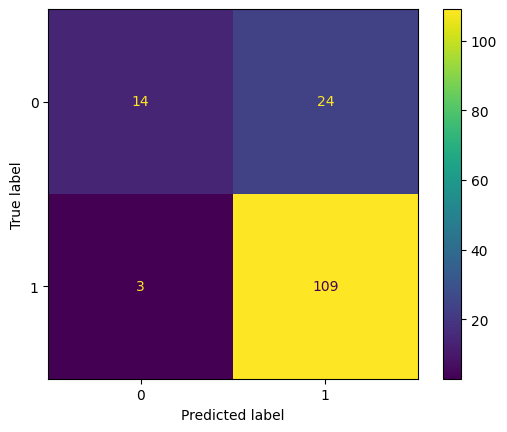

In [8]:
%%time

n_est = 200  # maximum number of trees in the random forest to optimize over
max_d = 20   # maximum depth of said trees to optimize over
metric = 'balanced_accuracy'  # the scoring for RandomizedSearchCV()

control_metrics(y_test)
print('')
orf = OptimalRF(X_train, X_test, y_train, y_test, n_est, max_d, metric)
orf.run()

In [6]:
# run the above cell three times, record the numbers and find the average - there's stochasicity in RandomizedSearchCV()

print("---- metric = 'accuracy' ----")
print("AVG Accuracy =", (0.8133333333333334 + )/3)
print("AVG Precision =", (0.823076923076923 + )/3)
print("AVG Recall =", (0.9553571428571429 + )/3)
print("AVG F1 =", (0.884297520661157 + )/3)

print("\n---- metric = 'balanced_accuracy' ----")
print("AVG Accuracy =", (0.82 + )/3)
print("AVG Precision =", (0.8195488721804511 + )/3)
print("AVG Recall =", (0.9732142857142857 + )/3)
print("AVG F1 =", (0.889795918367347 + )/3)

print("\n---- metric = 'recall' ----")
print("AVG Accuracy =", (0.8266666666666667 + )/3)
print("AVG Precision =", (0.8307692307692308 + )/3)
print("AVG Recall =", (0.9642857142857143 + )/3)
print("AVG F1 =", (0.8925619834710744 + )/3)

---- metric = 'accuracy' ----
AVG Accuracy = 0.8399122807017543
AVG Precision = 0.8448623136123136
AVG Recall = 0.9616519174041298
AVG F1 = 0.899398456582237

---- metric = 'balanced_accuracy' ----
AVG Accuracy = 0.8421052631578947
AVG Precision = 0.8510184556212024
AVG Recall = 0.9557522123893806
AVG F1 = 0.9000839917382392

---- metric = 'recall' ----
AVG Accuracy = 0.8486842105263158
AVG Precision = 0.8553680324843116
AVG Recall = 0.9587020648967552
AVG F1 = 0.9040517206225482


In [ ]:
# F- I-- N---